In [ ]:
!pip install google-generativeai openai

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import datetime as dt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import pointbiserialr
from sklearn.ensemble import IsolationForest
import os
import google.generativeai as genai
from google.colab import userdata
from openai import OpenAI
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
import shap
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

In [93]:
data = pd.read_csv('FinancialMarketData.xlsx - EWS.csv')

In [94]:
df = pd.DataFrame(data)
df

,Y,Data,XAU BGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,...,LP01TREU,EMUSTRUU,LF94TRUU,MXUS,MXEU,MXJP,MXBR,MXRU,MXIN,MXCN
0,0,1/11/2000,283.25,0.077,1388.0,157.2600,100.560,105.86,1.6460,25.77,...,116.4640,230.527,123.7620,1416.12,127.75,990.59,856.76,224.33,217.34,34.30
1,0,1/18/2000,287.65,0.043,1405.0,165.0100,101.860,105.47,1.6380,28.85,...,117.2670,231.377,123.7620,1428.79,129.50,993.98,925.22,234.37,227.08,32.74
2,0,1/25/2000,287.15,0.135,1368.0,167.2400,102.410,106.04,1.6500,28.28,...,117.9950,232.390,123.7620,1385.93,126.48,974.83,886.93,216.82,233.00,32.46
3,0,2/1/2000,282.75,0.191,1311.0,166.8500,104.920,107.85,1.6110,28.22,...,120.5100,231.942,122.3280,1385.31,129.19,1007.12,842.60,201.89,237.48,31.29
4,1,2/8/2000,298.40,0.312,1277.0,165.4300,104.220,109.30,1.6110,28.02,...,118.7910,237.812,122.3280,1411.95,134.67,1034.58,945.15,218.00,258.02,31.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,0,3/23/2021,1727.96,0.339,2271.0,184.5022,92.336,108.72,1.3760,57.76,...,427.7972,1249.403,389.8500,3800.77,140.32,1199.57,1671.73,681.21,1695.96,110.83
1107,0,3/30/2021,1685.56,0.303,2103.0,184.8741,93.297,110.29,1.3719,60.55,...,428.6578,1242.264,385.8145,3835.96,142.76,1206.29,1635.57,693.38,1690.76,108.80
1108,0,4/6/2021,1743.28,0.440,2092.0,185.8393,92.335,109.88,1.3822,59.33,...,430.6649,1250.256,390.6819,3955.16,144.13,1194.62,1689.62,673.20,1689.48,111.92
1109,0,4/13/2021,1742.69,0.467,2140.0,188.1368,91.852,109.19,1.3737,60.18,...,430.4087,1252.563,390.3848,4027.05,144.23,1197.06,1680.82,680.23,1672.46,108.40


In [ ]:
#Find correlations of features to Y
correlations=df.drop(columns = ['Data'])
print(correlations.corr())
correlations=correlations.drop("Y", axis=1).apply(lambda x: x.corr(df.Y))
correlations = correlations.sort_values(ascending=False)
correlations #Top ascending VIX GTIT2,10,30 EONIA

                  Y  XAU BGNL  ECSURPUS      BDIY       CRY       DXY  \
Y          1.000000 -0.011535 -0.090772 -0.083440 -0.074102  0.103227   
XAU BGNL  -0.011535  1.000000  0.114798 -0.315007  0.015316 -0.428891   
ECSURPUS  -0.090772  0.114798  1.000000 -0.102022 -0.139779  0.074835   
BDIY      -0.083440 -0.315007 -0.102022  1.000000  0.596182 -0.441793   
CRY       -0.074102  0.015316 -0.139779  0.596182  1.000000 -0.798564   
DXY        0.103227 -0.428891  0.074835 -0.441793 -0.798564  1.000000   
JPY       -0.151197 -0.576191 -0.070422  0.062822 -0.412364  0.650429   
GBP       -0.093201 -0.422084 -0.188233  0.756718  0.793954 -0.544966   
Cl1       -0.070141  0.515215 -0.016245  0.286396  0.785614 -0.816378   
VIX        0.598432 -0.075873 -0.094127 -0.045367 -0.190060  0.115712   
USGG30YR   0.019255 -0.868696 -0.015927  0.390852  0.256228  0.187296   
GT10      -0.004776 -0.893317 -0.016744  0.391498  0.178731  0.274784   
USGG2YR   -0.034909 -0.742875 -0.058576  0.324485  

,0
VIX,0.598432
GTITL2YR,0.304528
GTITL10YR,0.297573
GTITL30YR,0.295000
EONIA,0.180311
GTDEM30Y,0.141537
GTDEM10Y,0.139933
GTJPY10YR,0.133660
GTDEM2Y,0.130607
GTJPY30YR,0.114555


In [ ]:
client = OpenAI(api_key = userdata.get('OPEN_AI_KEY'))

In [ ]:
prompt = f"""You are an expert financial data analyst. You have a time series dataset of stock prices at certain dates, with 'Data' representing the date, and 'Y' as a binary target that represents whether an anomaly occured in the stock market on that date.
 Your goal is to develop a model that detects anomalies in the stock market based on this time series data. Each feature other than the 'Data' column represents a stock ticker. Let's go through the process step by step.

  Step 1. Your first step is to find what each stock ticker represents in the data
  Step 2. Your second step is to analyze the values of the stock tickers at each date and how the values differ than usual when the binary target('Y') is '1' (1 means anomaly occured on that date).
    This means you should look for outliers in the data such as sudden spikes in the prices of the stock tickers.
    Contextualize anomalous dates from 2000 to 2021 by matching them with dates of known black swan events, such as (but not limited to) the Dot Com Bubble, 2008 Financial Crisis and the COVID-19 pandemic
    In addition to the information from the dataset, you should consider the correlations of each stock ticker to the target column in your analysis. The list of correlations is given here:"{str(list(correlations))}
    These correlations can help you make a more accurate analysis of whether if a stock ticker is more suited for anomaly detection or not.
    Remember not to solely rely on the provided correlations as there may be other factors that can influence a stock ticker's reliability.

  Step 3. Your third step is to rank each of these stock tickers on reliability for anomaly detection. List out the top 15 most reliable and 15 least reliable stock tickers.

  Now, apply these steps in your analysis of the dataset. Do not just make suggestions or an outline, make sure to complete each step. Verify that the information in each step is correct.

  Do not give me hypothetical placeholder values anywhere, only use the tickers in the dataset
  """


user_prompt = f"This is the given dataset: {str(list(df))}"

response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "developer", "content": prompt},
        {"role": "user", "content": user_prompt}
    ]
)

# Print the  from the API
message = response.choices[0].message.content

In [ ]:
print(response.choices[0].message.content)

Great, let's proceed with the analysis by following the outlined steps:

### Step 1: Identify Stock Tickers

The given dataset comprises a list of stock tickers and financial indicators, here is what each ticker likely represents:

1. **'XAU BGNL'** - Gold (XAU is the trading symbol for one troy ounce of gold) expressed in a specific index or contract, possibly Bloomberg Gold Total Return.
2. **'ECSURPUS'** - U.S. Economic Surprise Index, which measures the degree of economic data variation from the consensus forecast.
3. **'BDIY'** - Baltic Dry Index, tracks rates to ship raw materials.
4. **'CRY'** - Refers to the Commodity Research Bureau index, which tracks commodity prices.
5. **'DXY'** - U.S. Dollar Index measuring the dollar value relative to a basket of foreign currencies.
6. **'JPY'** - Japanese Yen currency value.
7. **'GBP'** - British Pound currency value.
8. **'Cl1'** - Front month light sweet crude oil futures contract price.
9. **'VIX'** - CBOE Volatility Index, often ca

In [ ]:
features = df.drop(columns=['Y'])
features

,Data,XAU BGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,VIX,...,LP01TREU,EMUSTRUU,LF94TRUU,MXUS,MXEU,MXJP,MXBR,MXRU,MXIN,MXCN
0,1/11/2000,283.25,0.077,1388.0,157.2600,100.560,105.86,1.6460,25.77,22.50,...,116.4640,230.527,123.7620,1416.12,127.75,990.59,856.76,224.33,217.34,34.30
1,1/18/2000,287.65,0.043,1405.0,165.0100,101.860,105.47,1.6380,28.85,21.50,...,117.2670,231.377,123.7620,1428.79,129.50,993.98,925.22,234.37,227.08,32.74
2,1/25/2000,287.15,0.135,1368.0,167.2400,102.410,106.04,1.6500,28.28,23.02,...,117.9950,232.390,123.7620,1385.93,126.48,974.83,886.93,216.82,233.00,32.46
3,2/1/2000,282.75,0.191,1311.0,166.8500,104.920,107.85,1.6110,28.22,23.45,...,120.5100,231.942,122.3280,1385.31,129.19,1007.12,842.60,201.89,237.48,31.29
4,2/8/2000,298.40,0.312,1277.0,165.4300,104.220,109.30,1.6110,28.02,21.25,...,118.7910,237.812,122.3280,1411.95,134.67,1034.58,945.15,218.00,258.02,31.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,3/23/2021,1727.96,0.339,2271.0,184.5022,92.336,108.72,1.3760,57.76,20.30,...,427.7972,1249.403,389.8500,3800.77,140.32,1199.57,1671.73,681.21,1695.96,110.83
1107,3/30/2021,1685.56,0.303,2103.0,184.8741,93.297,110.29,1.3719,60.55,19.61,...,428.6578,1242.264,385.8145,3835.96,142.76,1206.29,1635.57,693.38,1690.76,108.80
1108,4/6/2021,1743.28,0.440,2092.0,185.8393,92.335,109.88,1.3822,59.33,18.12,...,430.6649,1250.256,390.6819,3955.16,144.13,1194.62,1689.62,673.20,1689.48,111.92
1109,4/13/2021,1742.69,0.467,2140.0,188.1368,91.852,109.19,1.3737,60.18,16.65,...,430.4087,1252.563,390.3848,4027.05,144.23,1197.06,1680.82,680.23,1672.46,108.40


In [ ]:
target = df['Y']
target

,Y
0,0
1,0
2,0
3,0
4,1
...,...
1106,0
1107,0
1108,0
1109,0


In [ ]:
count = 0
for i in target:
    if i == 1:
        count += 1
print(str((count/len(target))*100),"%")

21.332133213321335 %


In [ ]:
#Convert datetime of data['DATA']
features['Data'] = pd.to_datetime(df["Data"])

In [ ]:
features

,Data,XAU BGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,VIX,...,LP01TREU,EMUSTRUU,LF94TRUU,MXUS,MXEU,MXJP,MXBR,MXRU,MXIN,MXCN
0,2000-01-11,283.25,0.077,1388.0,157.2600,100.560,105.86,1.6460,25.77,22.50,...,116.4640,230.527,123.7620,1416.12,127.75,990.59,856.76,224.33,217.34,34.30
1,2000-01-18,287.65,0.043,1405.0,165.0100,101.860,105.47,1.6380,28.85,21.50,...,117.2670,231.377,123.7620,1428.79,129.50,993.98,925.22,234.37,227.08,32.74
2,2000-01-25,287.15,0.135,1368.0,167.2400,102.410,106.04,1.6500,28.28,23.02,...,117.9950,232.390,123.7620,1385.93,126.48,974.83,886.93,216.82,233.00,32.46
3,2000-02-01,282.75,0.191,1311.0,166.8500,104.920,107.85,1.6110,28.22,23.45,...,120.5100,231.942,122.3280,1385.31,129.19,1007.12,842.60,201.89,237.48,31.29
4,2000-02-08,298.40,0.312,1277.0,165.4300,104.220,109.30,1.6110,28.02,21.25,...,118.7910,237.812,122.3280,1411.95,134.67,1034.58,945.15,218.00,258.02,31.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,2021-03-23,1727.96,0.339,2271.0,184.5022,92.336,108.72,1.3760,57.76,20.30,...,427.7972,1249.403,389.8500,3800.77,140.32,1199.57,1671.73,681.21,1695.96,110.83
1107,2021-03-30,1685.56,0.303,2103.0,184.8741,93.297,110.29,1.3719,60.55,19.61,...,428.6578,1242.264,385.8145,3835.96,142.76,1206.29,1635.57,693.38,1690.76,108.80
1108,2021-04-06,1743.28,0.440,2092.0,185.8393,92.335,109.88,1.3822,59.33,18.12,...,430.6649,1250.256,390.6819,3955.16,144.13,1194.62,1689.62,673.20,1689.48,111.92
1109,2021-04-13,1742.69,0.467,2140.0,188.1368,91.852,109.19,1.3737,60.18,16.65,...,430.4087,1252.563,390.3848,4027.05,144.23,1197.06,1680.82,680.23,1672.46,108.40


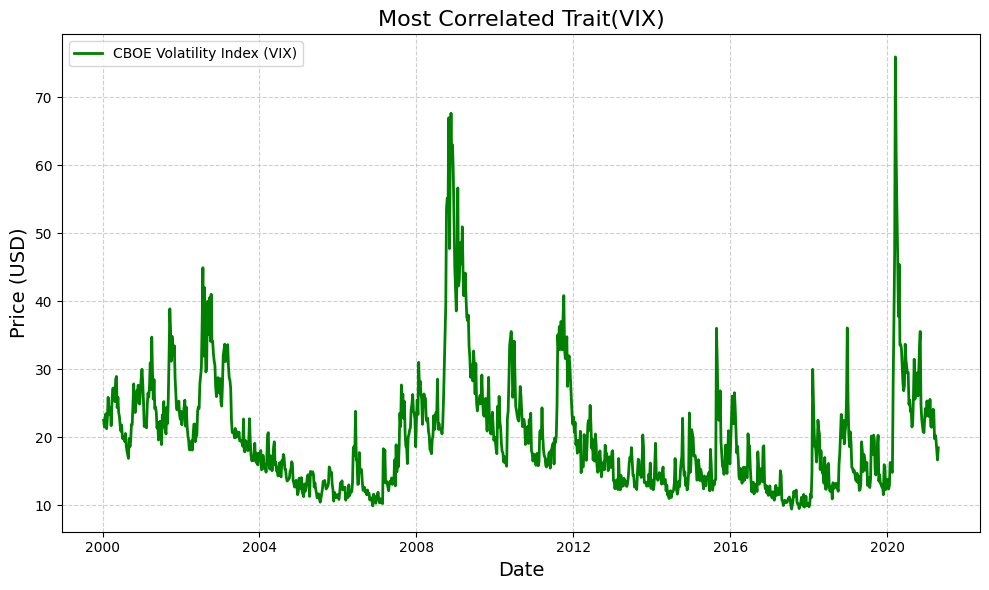

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(features['Data'], features['VIX'], label='CBOE Volatility Index (VIX)', color='green', linewidth=2)
plt.title('Most Correlated Trait(VIX)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

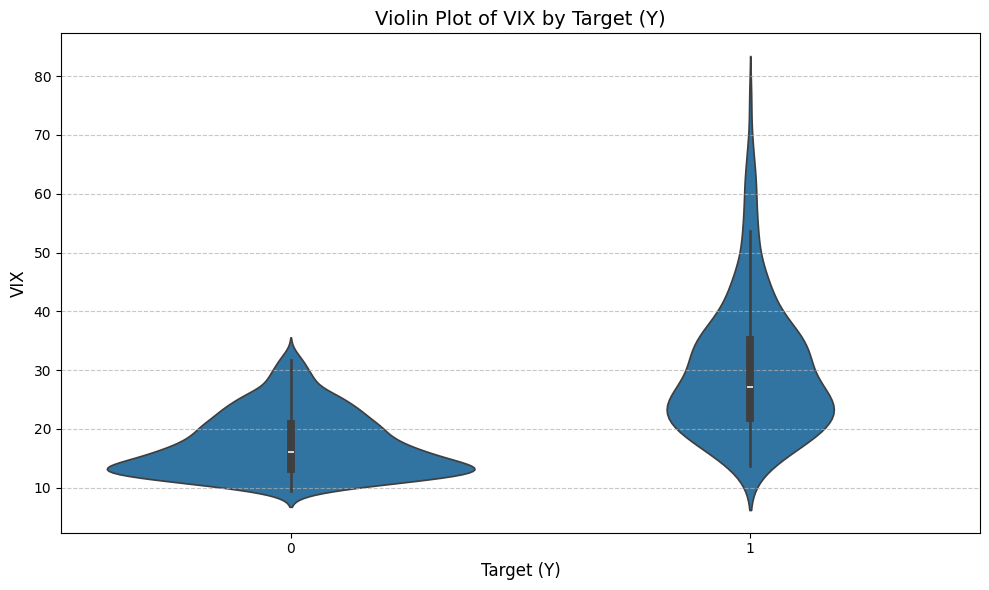

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Y', y='VIX', data=df)

plt.title('Violin Plot of VIX by Target (Y)', fontsize=14)
plt.xlabel('Target (Y)', fontsize=12)
plt.ylabel('VIX', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

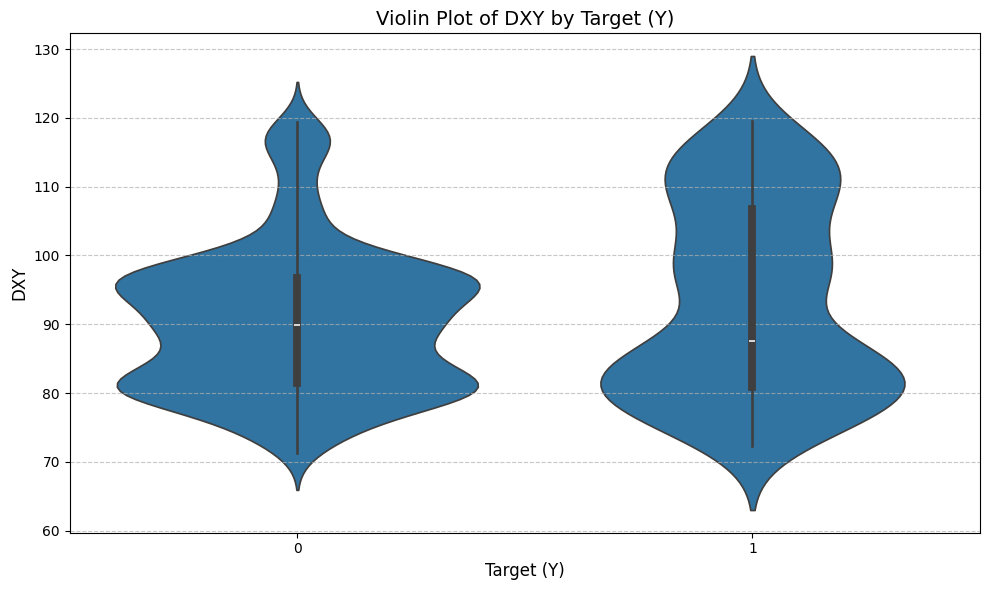

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Y', y='DXY', data=df)

plt.title('Violin Plot of DXY by Target (Y)', fontsize=14)
plt.xlabel('Target (Y)', fontsize=12)
plt.ylabel('DXY', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

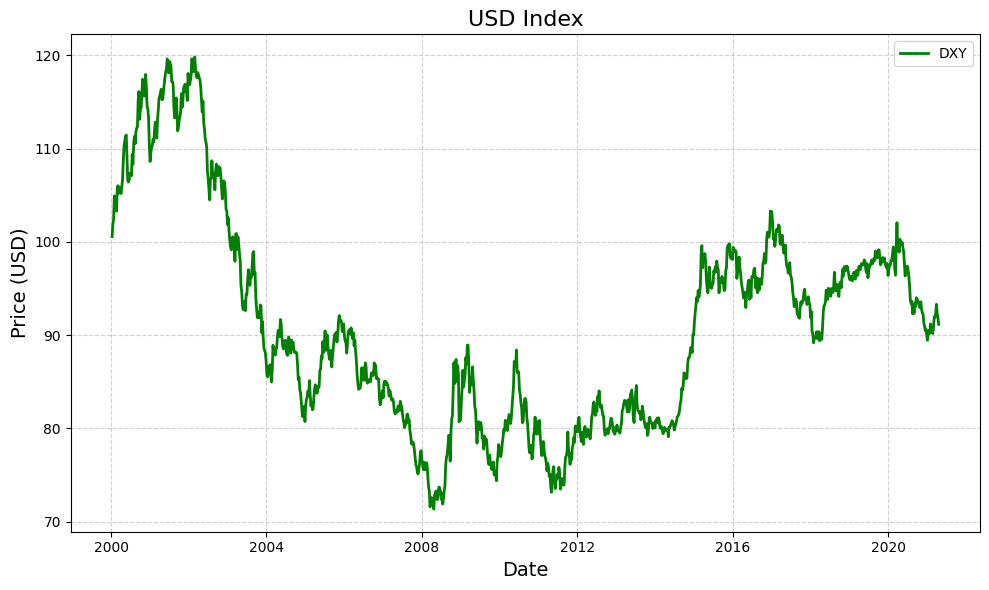

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(features['Data'], features['DXY'], label='DXY', color='green', linewidth=2)
plt.title('USD Index', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

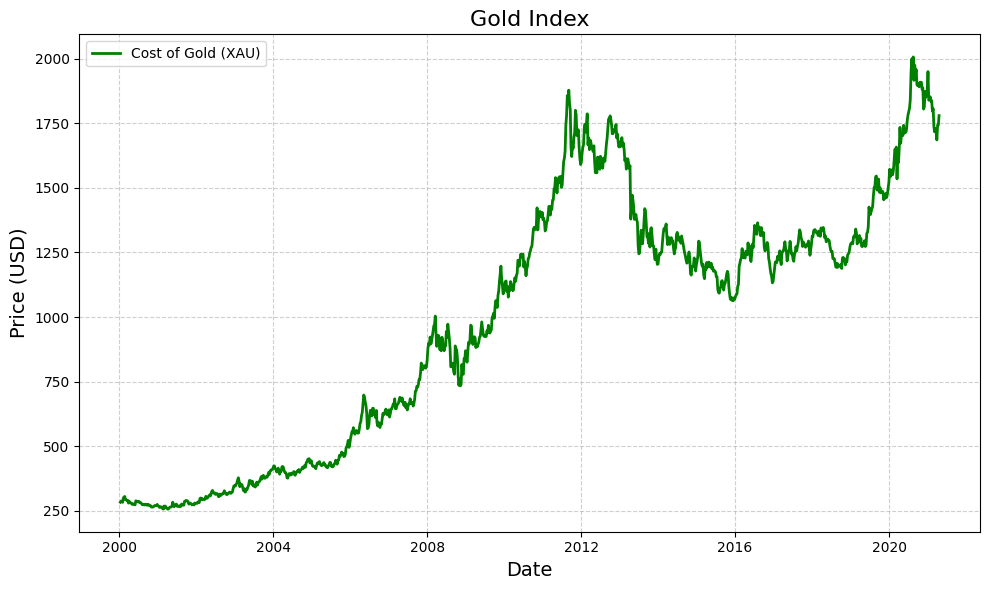

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(features['Data'], features['XAU BGNL'], label='Cost of Gold (XAU)', color='green', linewidth=2)
plt.title('Gold Index', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 3000x800 with 0 Axes>

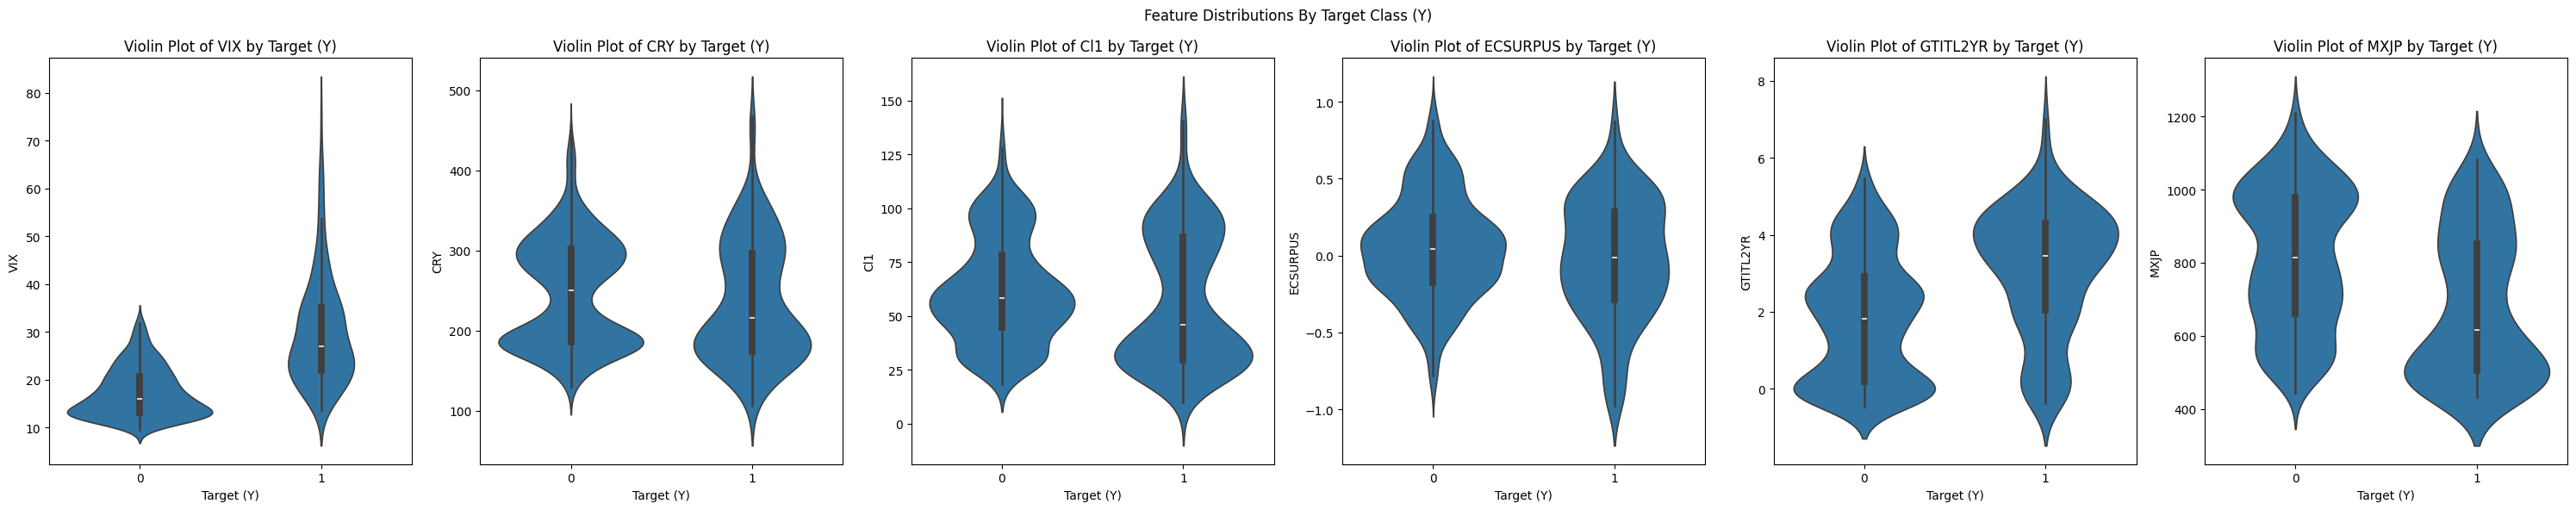

In [ ]:
plt.figure(figsize=(30, 8))
plot_features = ['VIX', 'CRY', 'Cl1', 'ECSURPUS', 'GTITL2YR' , 'MXJP']
fig, axes = plt.subplots(1, len(plot_features), figsize=(30, 6))
fig.suptitle('Feature Distributions By Target Class (Y)')


for i, column in enumerate(plot_features):
    sns.violinplot(x='Y', y=column, data=df, ax=axes[i], inner = 'box')

    axes[i].set_title(f'Violin Plot of {column} by Target (Y)')
    axes[i].set_xlabel('Target (Y)')

plt.tight_layout()
plt.show()

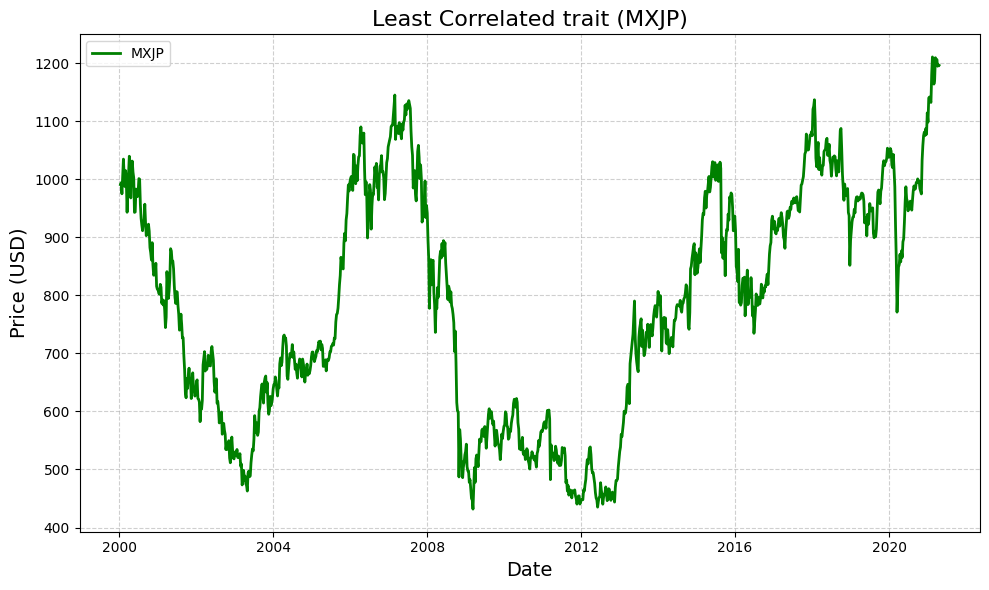

In [ ]:
plt.figure(figsize=(10, 6))
#plt.plot(train_data['Data'], train_data['MXJP'], label='MXJP', color='red', linewidth=2)
plt.plot(features['Data'], features['MXJP'], label='MXJP', color='green', linewidth=2)
plt.title('Least Correlated trait (MXJP)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

Simple LR

In [ ]:
train_data = features.drop(columns=['Data'])

In [ ]:
#Drop least correlated features
"""Based on hypothetical results:
Based on the provided correlations, stock tickers are ranked for their reliability in detecting anomalies. Here are the top 15 and least reliable 15:

**Top 15 Most Reliable Tickers (highest to lowest correlation with 'Y'):**
1. `XAU BGNL`: 0.5984
2. `ECSURPUS`: 0.3045
3. `BDIY`: 0.2976
4. `CRY`: 0.2950
5. `DXY`: 0.1803
6. `JPY`: 0.1415
7. `GBP`: 0.1399
8. `Cl1`: 0.1337
9. `VIX`: 0.1306
10. `USGG30YR`: 0.1146
11. `GT10`: 0.1123
12. `USGG2YR`: 0.1032
13. `USGG3M`: 0.1001
14. `US0001M`: 0.0998
15. `GTDEM30Y`: 0.0350

**15 Least Reliable Tickers (lowest to highest correlation with 'Y'):**
1. `MXCN`: -0.2794
2. `MXIN`: -0.2539
3. `MXRU`: -0.2098
4. `MXBR`: -0.1972
5. `GTJPY2YR`: -0.1939
6. `GTJPY10YR`: -0.1897
7. `GTJPY30YR`: -0.1889
8. `MXJP`: -0.1695
9. `MXEU`: -0.1566
10. `MXUS`: -0.1535
11. `GTGBP2Y`: -0.1512
12. `GTGBP20Y`: -0.1496
13. `GTGBP30Y`: -0.1488
14. `GTITL2YR`: -0.1436
15. `GTITL10YR`: -0.1049

The correlations indicate which stock tickers are more strongly associated with anomalies. However, further analysis and context consideration are needed for a comprehensive model for anomaly detection.
"""


"Based on hypothetical results:\nBased on the provided correlations, stock tickers are ranked for their reliability in detecting anomalies. Here are the top 15 and least reliable 15:\n\n**Top 15 Most Reliable Tickers (highest to lowest correlation with 'Y'):**\n1. `XAU BGNL`: 0.5984\n2. `ECSURPUS`: 0.3045\n3. `BDIY`: 0.2976\n4. `CRY`: 0.2950\n5. `DXY`: 0.1803\n6. `JPY`: 0.1415\n7. `GBP`: 0.1399\n8. `Cl1`: 0.1337\n9. `VIX`: 0.1306\n10. `USGG30YR`: 0.1146\n11. `GT10`: 0.1123\n12. `USGG2YR`: 0.1032\n13. `USGG3M`: 0.1001\n14. `US0001M`: 0.0998\n15. `GTDEM30Y`: 0.0350\n\n**15 Least Reliable Tickers (lowest to highest correlation with 'Y'):**\n1. `MXCN`: -0.2794\n2. `MXIN`: -0.2539\n3. `MXRU`: -0.2098\n4. `MXBR`: -0.1972\n5. `GTJPY2YR`: -0.1939\n6. `GTJPY10YR`: -0.1897\n7. `GTJPY30YR`: -0.1889\n8. `MXJP`: -0.1695\n9. `MXEU`: -0.1566\n10. `MXUS`: -0.1535\n11. `GTGBP2Y`: -0.1512\n12. `GTGBP20Y`: -0.1496\n13. `GTGBP30Y`: -0.1488\n14. `GTITL2YR`: -0.1436\n15. `GTITL10YR`: -0.1049\n\nThe correlat

In [ ]:
train_data = train_data[['BDIY', 'DXY', 'JPY', 'VIX', 'GT10','CRY','Cl1','GTITL2YR', 'XAU BGNL']]

In [ ]:
train_data

,BDIY,DXY,JPY,VIX,GT10,CRY,Cl1,GTITL2YR,XAU BGNL
0,1388.0,100.560,105.86,22.50,6.657,157.2600,25.77,4.495,283.25
1,1405.0,101.860,105.47,21.50,6.748,165.0100,28.85,4.535,287.65
2,1368.0,102.410,106.04,23.02,6.692,167.2400,28.28,4.511,287.15
3,1311.0,104.920,107.85,23.45,6.619,166.8500,28.22,4.540,282.75
4,1277.0,104.220,109.30,21.25,6.613,165.4300,28.02,4.638,298.40
...,...,...,...,...,...,...,...,...,...
1106,2271.0,92.336,108.72,20.30,1.622,184.5022,57.76,-0.415,1727.96
1107,2103.0,93.297,110.29,19.61,1.706,184.8741,60.55,-0.382,1685.56
1108,2092.0,92.335,109.88,18.12,1.658,185.8393,59.33,-0.377,1743.28
1109,2140.0,91.852,109.19,16.65,1.616,188.1368,60.18,-0.363,1742.69


In [ ]:
train_data, target

(        BDIY      DXY     JPY    VIX   GT10       CRY    Cl1  GTITL2YR  \
 0     1388.0  100.560  105.86  22.50  6.657  157.2600  25.77     4.495   
 1     1405.0  101.860  105.47  21.50  6.748  165.0100  28.85     4.535   
 2     1368.0  102.410  106.04  23.02  6.692  167.2400  28.28     4.511   
 3     1311.0  104.920  107.85  23.45  6.619  166.8500  28.22     4.540   
 4     1277.0  104.220  109.30  21.25  6.613  165.4300  28.02     4.638   
 ...      ...      ...     ...    ...    ...       ...    ...       ...   
 1106  2271.0   92.336  108.72  20.30  1.622  184.5022  57.76    -0.415   
 1107  2103.0   93.297  110.29  19.61  1.706  184.8741  60.55    -0.382   
 1108  2092.0   92.335  109.88  18.12  1.658  185.8393  59.33    -0.377   
 1109  2140.0   91.852  109.19  16.65  1.616  188.1368  60.18    -0.363   
 1110  2432.0   91.147  108.09  18.46  1.565  193.8035  62.50    -0.352   
 
       XAU BGNL  
 0       283.25  
 1       287.65  
 2       287.15  
 3       282.75  
 4      

# Finding top Features

Test to find most important features from Logistic Regression, XGBoost, Isolation Forest

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_data, target, test_size=0.2, random_state=42)

In [ ]:
SMOTE = SMOTE(random_state=42)
X_train, y_train = SMOTE.fit_resample(X_train, y_train)#Smote makes it worse

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
lr_model = LogisticRegression(solver = 'liblinear', C = 2.0, max_iter = 1000, class_weight = 'balanced')

In [ ]:
def evaluate_and_save_model(model, X_train, X_test, y_train, y_test, filename):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model.__class__.__name__} Accuracy: {accuracy:.4f}")

    print(f"\nClassification Report:\n{classification_report(y_test,y_pred)}")
    print("------")

    with open(filename, "wb") as file:
      pickle.dump(model, file)

      print(f"Model saved as: {filename}")

In [ ]:
evaluate_and_save_model(lr_model, X_train, X_test, y_train, y_test, "lr_model.pkl")

LogisticRegression Accuracy: 0.7309

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.69      0.80       177
           1       0.43      0.89      0.58        46

    accuracy                           0.73       223
   macro avg       0.69      0.79      0.69       223
weighted avg       0.85      0.73      0.76       223

------
Model saved as: lr_model.pkl


In [ ]:
model_fi = permutation_importance(lr_model, X_train, y_train)
model_fi['importances_mean']

array([0.01061693, 0.04275466, 0.02482066, 0.2733142 , 0.03070301,
       0.00028694, 0.04088953, 0.19971306, 0.03873745])

In [ ]:
feature_names = train_data.columns
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model_fi['importances_mean']
})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

    Feature  Importance
3       VIX    0.273314
7  GTITL2YR    0.199713
1       DXY    0.042755
6       Cl1    0.040890
8  XAU BGNL    0.038737
4      GT10    0.030703
2       JPY    0.024821
0      BDIY    0.010617
5       CRY    0.000287


In [ ]:
train_data.columns #If Thhe above outputs very good features, get them

Index(['BDIY', 'DXY', 'JPY', 'VIX', 'GT10', 'CRY', 'Cl1', 'GTITL2YR',
       'XAU BGNL'],
      dtype='object')

Isolation Forest

In [ ]:
iso_model = IsolationForest(n_estimators=50, max_samples='auto', contamination=0.21, max_features=1.0)
iso_model.fit(train_data[['BDIY', 'DXY', 'JPY', 'VIX', 'GT10', 'CRY', 'Cl1', 'GTITL2YR',
       'XAU BGNL']])


IsolationForest(contamination=0.21, n_estimators=50)

In [ ]:
#Default training data for testing
train_data =train_data[['BDIY', 'DXY', 'JPY', 'VIX', 'GT10', 'CRY', 'Cl1', 'GTITL2YR',
       'XAU BGNL']]

In [ ]:
train_data['scores']=iso_model.decision_function(train_data[['BDIY', 'DXY', 'JPY', 'VIX', 'GT10', 'CRY', 'Cl1', 'GTITL2YR',
       'XAU BGNL']])
train_data['anomaly']=iso_model.predict(train_data[['BDIY', 'DXY', 'JPY', 'VIX', 'GT10', 'CRY', 'Cl1', 'GTITL2YR',
       'XAU BGNL']])

In [ ]:
train_data['anomaly'] = train_data['anomaly'].replace({-1: 1, 1: 0})

In [ ]:
print("Percentage of outliers in data: {:.2f}%".format(len(train_data[train_data['anomaly'] == 1]) / len(train_data) * 100))

Percentage of outliers in data: 21.06%


In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
print(classification_report(target, train_data['anomaly']))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       874
           1       0.48      0.48      0.48       237

    accuracy                           0.78      1111
   macro avg       0.67      0.67      0.67      1111
weighted avg       0.78      0.78      0.78      1111



In [ ]:
exp = shap.TreeExplainer(iso_model) #Explainer
shap_values = exp.shap_values(train_data[['BDIY', 'DXY', 'JPY', 'VIX', 'GT10', 'CRY', 'Cl1', 'GTITL2YR',
       'XAU BGNL']])

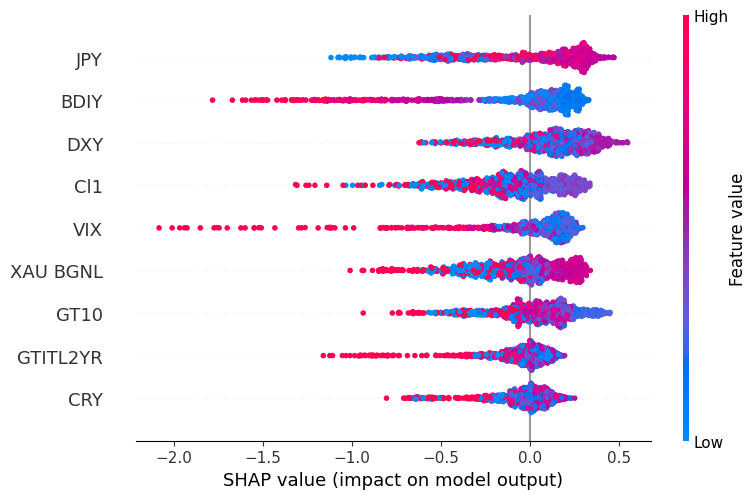

In [ ]:
shap.summary_plot(shap_values,train_data[['BDIY', 'DXY', 'JPY', 'VIX', 'GT10', 'CRY', 'Cl1', 'GTITL2YR',
       'XAU BGNL']], max_display=train_data.shape[1])

# **Feature Engineering and Applying Methods**


In [246]:
df = pd.read_csv('FinancialMarketData.xlsx - EWS.csv', parse_dates=['Data'])

##Moving Average and Splitting Method

In [247]:
df_rolling = df[['Data', 'DXY', 'JPY', 'VIX', 'GTITL2YR',
       'XAU BGNL', 'Y']]

In [248]:
def apply_rolling_average(df, window):
    excluded_columns = {'Month', 'Year', 'Day', 'Data', 'Y', 'USD_Over_100'}
    for col in df.columns:
        if col not in excluded_columns:
            df[f"{col}_rolling_avg_{window}"] = df[col].rolling(window=window).mean()

    return df


In [249]:
apply_rolling_average(df_rolling, 5)
apply_rolling_average(df_rolling, 20)

,Data,DXY,JPY,VIX,GTITL2YR,XAU BGNL,Y,DXY_rolling_avg_5,JPY_rolling_avg_5,VIX_rolling_avg_5,...,DXY_rolling_avg_20,JPY_rolling_avg_20,VIX_rolling_avg_20,GTITL2YR_rolling_avg_20,XAU BGNL_rolling_avg_20,DXY_rolling_avg_5_rolling_avg_20,JPY_rolling_avg_5_rolling_avg_20,VIX_rolling_avg_5_rolling_avg_20,GTITL2YR_rolling_avg_5_rolling_avg_20,XAU BGNL_rolling_avg_5_rolling_avg_20
0,2000-01-11,100.560,105.86,22.50,4.495,283.25,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-18,101.860,105.47,21.50,4.535,287.65,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01-25,102.410,106.04,23.02,4.511,287.15,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-02-01,104.920,107.85,23.45,4.540,282.75,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-02-08,104.220,109.30,21.25,4.638,298.40,1,102.7940,106.904,22.344,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,2021-03-23,92.336,108.72,20.30,-0.415,1727.96,0,91.4226,107.648,22.266,...,91.01225,105.0805,22.7855,-0.38390,1826.5010,91.14282,104.7028,23.9284,-0.38016,1844.5203
1107,2021-03-30,93.297,110.29,19.61,-0.382,1685.56,0,92.0482,108.658,21.566,...,91.03965,105.3300,22.5260,-0.38400,1816.6850,91.08683,104.8824,23.5155,-0.38131,1835.4830
1108,2021-04-06,92.335,109.88,18.12,-0.377,1743.28,0,92.3582,109.286,20.370,...,91.03560,105.6125,22.2965,-0.38330,1809.5020,91.05749,105.1065,23.0764,-0.38237,1826.5553
1109,2021-04-13,91.852,109.19,16.65,-0.363,1742.69,0,92.3370,109.418,18.894,...,91.01690,105.8405,22.0470,-0.38055,1806.3845,91.03550,105.3466,22.6406,-0.38250,1818.9257


In [250]:
def apply_cross(df, w1, w2):
  excluded_columns = {'Month', 'Year', 'Day', 'Data', 'Y', 'USD_Over_100'}
  for col in df.columns:
    if col not in excluded_columns and "rolling_avg" not in col:
      df[f"{col}_cross"] = (df[f"{col}_rolling_avg_{w1}"] > df[f"{col}_rolling_avg_{w2}"]).astype(int)
  return df

In [251]:
apply_cross(df_rolling, 5, 20)

,Data,DXY,JPY,VIX,GTITL2YR,XAU BGNL,Y,DXY_rolling_avg_5,JPY_rolling_avg_5,VIX_rolling_avg_5,...,DXY_rolling_avg_5_rolling_avg_20,JPY_rolling_avg_5_rolling_avg_20,VIX_rolling_avg_5_rolling_avg_20,GTITL2YR_rolling_avg_5_rolling_avg_20,XAU BGNL_rolling_avg_5_rolling_avg_20,DXY_cross,JPY_cross,VIX_cross,GTITL2YR_cross,XAU BGNL_cross
0,2000-01-11,100.560,105.86,22.50,4.495,283.25,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
1,2000-01-18,101.860,105.47,21.50,4.535,287.65,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
2,2000-01-25,102.410,106.04,23.02,4.511,287.15,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
3,2000-02-01,104.920,107.85,23.45,4.540,282.75,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
4,2000-02-08,104.220,109.30,21.25,4.638,298.40,1,102.7940,106.904,22.344,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,2021-03-23,92.336,108.72,20.30,-0.415,1727.96,0,91.4226,107.648,22.266,...,91.14282,104.7028,23.9284,-0.38016,1844.5203,1,1,0,1,0
1107,2021-03-30,93.297,110.29,19.61,-0.382,1685.56,0,92.0482,108.658,21.566,...,91.08683,104.8824,23.5155,-0.38131,1835.4830,1,1,0,1,0
1108,2021-04-06,92.335,109.88,18.12,-0.377,1743.28,0,92.3582,109.286,20.370,...,91.05749,105.1065,23.0764,-0.38237,1826.5553,1,1,0,0,0
1109,2021-04-13,91.852,109.19,16.65,-0.363,1742.69,0,92.3370,109.418,18.894,...,91.03550,105.3466,22.6406,-0.38250,1818.9257,1,1,0,0,0


In [252]:
df_rolling['USD_Over_100'] = df_rolling['DXY'] > 100

In [253]:
df_rolling = df_rolling[['Data', 'DXY', "JPY", "VIX", "GTITL2YR", "XAU BGNL", "Y", "XAU BGNL_cross", "VIX_cross", "USD_Over_100"]]

In [254]:
corr = df_rolling.corr()['Y']
print(corr)


Data             -0.136997
DXY               0.103227
JPY              -0.151197
VIX               0.598432
GTITL2YR          0.304528
XAU BGNL         -0.011535
Y                 1.000000
XAU BGNL_cross   -0.035225
VIX_cross         0.197619
USD_Over_100      0.203685
Name: Y, dtype: float64


In [255]:
def split_timeseries(df, train_years, val_years, total_years ):
  df['Data'] = pd.to_datetime(df['Data'])
  df = df.sort_values('Data')

  train_size = train_years*52
  test_start = train_size + val_years*52
  total_weeks = total_years*52
  if total_years > len(df):
    raise ValueError("Total years cannot be greater than the length of the DataFrame.")

  training_data = df.iloc[:train_size]
  validation_data = df.iloc[train_size:test_start ]
  test_data = df.iloc[test_start: total_weeks]

  print(f"Training data starts from {training_data['Data'].min()} and ends on {training_data['Data'].max()}")
  print(f"Validation data starts from {validation_data['Data'].min()} and ends on {validation_data['Data'].max()}")
  print(f"Test data starts from {test_data['Data'].min()} and ends on {test_data['Data'].max()}")

  return training_data, validation_data, test_data

In [256]:
train_split, val_split, test_split = split_timeseries(df_rolling, train_years = 9, val_years = 2, total_years = 12)

Training data starts from 2000-01-11 00:00:00 and ends on 2008-12-23 00:00:00
Validation data starts from 2008-12-30 00:00:00 and ends on 2010-12-21 00:00:00
Test data starts from 2010-12-28 00:00:00 and ends on 2011-12-20 00:00:00


In [257]:
train_split = train_split.drop(columns=['Data'])
val_split = val_split.drop(columns=['Data'])
test_split = test_split.drop(columns=['Data'])

In [258]:
X_train = train_split.drop(columns=['Y'])
y_train = train_split['Y']

X_val = val_split.drop(columns=['Y'])
y_val = val_split['Y']

X_test = test_split.drop(columns=['Y'])
y_test = test_split['Y']


In [259]:
X_val

,DXY,JPY,VIX,GTITL2YR,XAU BGNL,XAU BGNL_cross,VIX_cross,USD_Over_100
468,80.899,90.34,41.63,3.098,869.90,1,1,False
469,82.850,94.06,38.56,2.988,857.60,1,1,False
470,84.265,89.53,43.27,2.650,825.35,1,0,False
471,86.216,90.13,56.65,2.581,859.95,1,0,False
472,84.426,88.88,42.25,2.650,901.75,1,0,False
...,...,...,...,...,...,...,...,...
567,79.681,82.84,20.63,2.411,1380.05,1,0,False
568,81.195,83.61,23.54,2.982,1388.53,1,0,False
569,79.857,83.27,17.99,2.399,1408.68,1,0,False
570,79.367,83.42,17.61,2.549,1403.46,1,0,False


In [260]:
X_train.columns

Index(['DXY', 'JPY', 'VIX', 'GTITL2YR', 'XAU BGNL', 'XAU BGNL_cross',
       'VIX_cross', 'USD_Over_100'],
      dtype='object')

In [261]:
lr_model = LogisticRegression(C=0.1, class_weight='balanced')
lr_model.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced')

In [262]:
val_predictions = lr_model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, val_predictions))
print(f"\nClassification Report:\n{classification_report(y_val,val_predictions)}")
print("------")


# 5. Test the Model
test_predictions = lr_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, test_predictions))
print(f"\nClassification Report:\n{classification_report(y_test,test_predictions)}")
print("------")

Validation Accuracy: 0.8173076923076923

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86        69
           1       0.74      0.71      0.72        35

    accuracy                           0.82       104
   macro avg       0.80      0.79      0.79       104
weighted avg       0.82      0.82      0.82       104

------
Test Accuracy: 0.8846153846153846

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        29
           1       0.90      0.83      0.86        23

    accuracy                           0.88        52
   macro avg       0.89      0.88      0.88        52
weighted avg       0.89      0.88      0.88        52

------


Training


In [263]:
import json

In [264]:
def save_evaluation(model, X_train, X_test, y_train, y_test, json_file_path):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report_dict = classification_report(y_test,y_pred)
    with open(json_file_path, "w") as json_file:
      json.dump(report_dict, json_file, indent=4)
    print(f"Metrics saved as: {json_file_path}")


In [178]:
def evaluate_and_save_model(model, X_train, X_test, y_train, y_test, filename):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model.__class__.__name__} Accuracy: {accuracy:.4f}")

    print(f"\nClassification Report:\n{classification_report(y_test,y_pred)}")
    print("------")

    with open(filename, "wb") as file:
      pickle.dump(model, file)

      print(f"Model saved as: {filename}")

In [265]:
save_evaluation(lr_model, X_train, X_test, y_train, y_test, "lr_model_features.json")

Metrics saved as: lr_model_features.json


In [179]:
evaluate_and_save_model(lr_model, X_train, X_test, y_train, y_test, "lr_model_features.pkl")

LogisticRegression Accuracy: 0.8846

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        29
           1       0.90      0.83      0.86        23

    accuracy                           0.88        52
   macro avg       0.89      0.88      0.88        52
weighted avg       0.89      0.88      0.88        52

------
Model saved as: lr_model_features.pkl


In [123]:
iso_model = IsolationForest(n_estimators=500, contamination='auto', max_features=1.0, random_state = 42, warm_start = True, n_jobs = 1)
iso_features = ["VIX","USD_Over_100", "XAU BGNL_cross"]

In [124]:
iso_model.fit(X_train[iso_features], y_train)

IsolationForest(n_estimators=500, n_jobs=1, random_state=42, warm_start=True)

In [125]:
val_predictions = iso_model.predict(X_val[iso_features])
val_predictions = np.where(val_predictions == -1, 1, 0)
print("Validation Accuracy:", accuracy_score(y_val, val_predictions))
print(f"\nClassification Report:\n{classification_report(y_val,val_predictions)}")
print("------")


# 5. Test the Model
test_predictions = iso_model.predict(X_test[iso_features])
test_predictions = np.where(test_predictions == -1, 1, 0)
print("Test Accuracy:", accuracy_score(y_test, test_predictions))
print(f"\nClassification Report:\n{classification_report(y_test,test_predictions)}")
print("------")

Validation Accuracy: 0.7307692307692307

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.61      0.75        69
           1       0.56      0.97      0.71        35

    accuracy                           0.73       104
   macro avg       0.77      0.79      0.73       104
weighted avg       0.84      0.73      0.74       104

------
Test Accuracy: 0.8653846153846154

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.86      0.83      0.84        23

    accuracy                           0.87        52
   macro avg       0.87      0.86      0.86        52
weighted avg       0.87      0.87      0.87        52

------


In [126]:
exp = shap.TreeExplainer(iso_model) #Explainer
shap_values = exp.shap_values(X_train[iso_features])

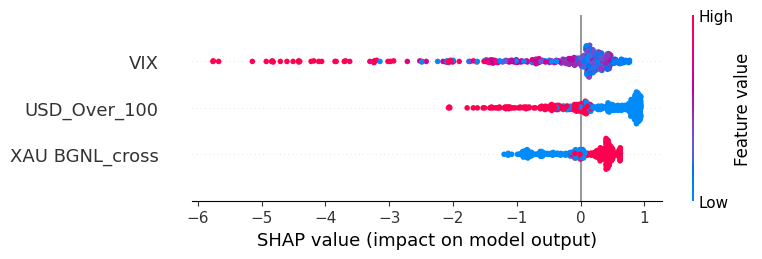

In [127]:
shap.summary_plot(shap_values,X_train[iso_features], max_display=X_train.shape[1])

In [128]:
X_train

,DXY,JPY,VIX,GTITL2YR,XAU BGNL,XAU BGNL_cross,VIX_cross,USD_Over_100
0,100.560,105.86,22.50,4.495,283.25,0,0,True
1,101.860,105.47,21.50,4.535,287.65,0,0,True
2,102.410,106.04,23.02,4.511,287.15,0,0,True
3,104.920,107.85,23.45,4.540,282.75,0,0,True
4,104.220,109.30,21.25,4.638,298.40,0,0,True
...,...,...,...,...,...,...,...,...
463,85.000,95.14,60.90,3.383,816.60,0,1,False
464,86.702,93.57,62.98,3.323,782.18,0,1,False
465,85.837,92.29,58.91,3.397,778.37,0,1,False
466,80.683,90.06,52.37,3.287,839.00,0,1,False


In [129]:
with open("iso_model.pkl", "wb") as file:
      pickle.dump("iso_model.pkl", file)



##Decision Tree


In [130]:
from sklearn.tree import DecisionTreeClassifier

In [131]:
dt_model = DecisionTreeClassifier(max_depth=100, random_state=42)

In [132]:
X_train.columns

Index(['DXY', 'JPY', 'VIX', 'GTITL2YR', 'XAU BGNL', 'XAU BGNL_cross',
       'VIX_cross', 'USD_Over_100'],
      dtype='object')

In [133]:
dt_features = ['DXY', 'JPY', 'VIX', 'GTITL2YR', 'XAU BGNL', 'XAU BGNL_cross',
       'VIX_cross', 'USD_Over_100']

In [134]:
dt_model.fit(X_train[dt_features], y_train)

DecisionTreeClassifier(max_depth=100, random_state=42)

In [135]:
val_predictions = dt_model.predict(X_val[dt_features])
print("Validation Accuracy:", accuracy_score(y_val, val_predictions))
print(f"\nClassification Report (Validation):\n{classification_report(y_val, val_predictions)}")
print("------")

test_predictions = dt_model.predict(X_test[dt_features])
print("Test Accuracy:", accuracy_score(y_test, test_predictions))
print(f"\nClassification Report (Test):\n{classification_report(y_test, test_predictions)}")
print("------")

Validation Accuracy: 0.8076923076923077

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        69
           1       0.71      0.71      0.71        35

    accuracy                           0.81       104
   macro avg       0.78      0.78      0.78       104
weighted avg       0.81      0.81      0.81       104

------
Test Accuracy: 0.8653846153846154

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.84      0.93      0.89        29
           1       0.90      0.78      0.84        23

    accuracy                           0.87        52
   macro avg       0.87      0.86      0.86        52
weighted avg       0.87      0.87      0.86        52

------


In [136]:
with open("dt_model.pkl", "wb") as file:
      pickle.dump("dt_model.pkl", file)


In [137]:
from sklearn.ensemble import RandomForestClassifier

In [138]:
rf_features = ['DXY', 'JPY', 'VIX', 'GTITL2YR', 'XAU BGNL', 'XAU BGNL_cross',
       'VIX_cross', 'USD_Over_100']

In [139]:
rf_model = RandomForestClassifier(
    n_estimators=500,    # Number of trees in the forest
    max_depth=100,      # Maximum depth of each tree
    random_state=42,     # Ensures reproducibility
    n_jobs=-1            # Use all available cores for training
)

rf_model.fit(X_train[rf_features], y_train)

val_predictions = rf_model.predict(X_val[rf_features])
print("Validation Accuracy:", accuracy_score(y_val, val_predictions))
print(f"\nClassification Report (Validation):\n{classification_report(y_val, val_predictions)}")
print("------")

test_predictions = rf_model.predict(X_test[rf_features])
print("Test Accuracy:", accuracy_score(y_test, test_predictions))
print(f"\nClassification Report (Test):\n{classification_report(y_test, test_predictions)}")
print("------")


Validation Accuracy: 0.8557692307692307

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.86      0.93      0.90        69
           1       0.83      0.71      0.77        35

    accuracy                           0.86       104
   macro avg       0.85      0.82      0.83       104
weighted avg       0.85      0.86      0.85       104

------
Test Accuracy: 0.8269230769230769

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.79      0.93      0.86        29
           1       0.89      0.70      0.78        23

    accuracy                           0.83        52
   macro avg       0.84      0.81      0.82        52
weighted avg       0.84      0.83      0.82        52

------


In [140]:
with open("rf_model.pkl", "wb") as file:
      pickle.dump("rf_model.pkl", file)

##Milestone 2

In [2]:
!pip install yfinance

In [266]:
import yfinance as yf
import datetime
import joblib
import google.generativeai as genai
google_api_key = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=google_api_key)

In [267]:
top_features = ['DXY', 'JPY', 'VIX', 'GTITL2YR', 'XAU BGNL', 'XAU BGNL_cross',
       'VIX_cross', 'USD_Over_100']

In [268]:
vix_ticker = yf.Ticker("^VIX")
today = datetime.date.today().strftime("%Y-%m-%d")
vix_data = vix_ticker.history(start="2021-01-05", end=today)
vix_data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-01-13 00:00:00-05:00,21.180000,22.040001,19.15,19.190001,0,0.0,0.0
2025-01-14 00:00:00-05:00,18.790001,19.660000,18.24,18.709999,0,0.0,0.0
2025-01-15 00:00:00-05:00,19.080000,19.139999,15.96,16.120001,0,0.0,0.0
2025-01-16 00:00:00-05:00,15.870000,16.600000,15.64,16.600000,0,0.0,0.0
2025-01-17 00:00:00-05:00,16.190001,16.230000,15.53,15.970000,0,0.0,0.0


In [269]:
vix_data= vix_data.drop(columns=['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])

In [270]:
vix_data

,Close
Date,
2021-01-05 00:00:00-05:00,25.340000
2021-01-06 00:00:00-05:00,25.070000
2021-01-07 00:00:00-05:00,22.370001
2021-01-08 00:00:00-05:00,21.559999
2021-01-11 00:00:00-05:00,24.080000
...,...
2025-01-13 00:00:00-05:00,19.190001
2025-01-14 00:00:00-05:00,18.709999
2025-01-15 00:00:00-05:00,16.120001


In [271]:
tickers = ['DXY', 'JPY', 'VIX', 'GTITL2YR', 'XAU BGNL']
ranges = {
    'DXY': (90, 110),
    'JPY': (100, 150),
    'VIX': (10, 40),
    'GTITL2YR': (0.5, 5.0),
    'XAU BGNL': (1700, 2000)
}
start_date = dt.datetime(2021, 1, 5)
end_date = dt.datetime(2024, 12, 31)

In [272]:
dates = pd.date_range(start=start_date, end=end_date, freq="W-TUE")
data = {"Data": dates}

In [273]:
data

{'Data': DatetimeIndex(['2021-01-05', '2021-01-12', '2021-01-19', '2021-01-26',
                '2021-02-02', '2021-02-09', '2021-02-16', '2021-02-23',
                '2021-03-02', '2021-03-09',
                ...
                '2024-10-29', '2024-11-05', '2024-11-12', '2024-11-19',
                '2024-11-26', '2024-12-03', '2024-12-10', '2024-12-17',
                '2024-12-24', '2024-12-31'],
               dtype='datetime64[ns]', length=209, freq='W-TUE')}

In [274]:
for ticker in tickers:
    data[ticker] = np.random.uniform(*ranges[ticker], len(dates))

In [275]:
new_df = pd.DataFrame(data)
new_df

,Data,DXY,JPY,VIX,GTITL2YR,XAU BGNL
0,2021-01-05,104.677668,144.411922,16.534352,4.794024,1773.328821
1,2021-01-12,96.686619,135.897784,24.937166,2.613617,1969.149712
2,2021-01-19,101.847655,133.589356,29.597442,4.650698,1978.559381
3,2021-01-26,94.534055,140.526767,15.987424,3.255422,1860.558501
4,2021-02-02,98.417232,112.779071,18.422092,2.212781,1918.169931
...,...,...,...,...,...,...
204,2024-12-03,93.096410,114.927348,37.143626,1.448792,1855.799539
205,2024-12-10,101.093377,130.322692,16.642676,0.639507,1738.016089
206,2024-12-17,102.193308,123.024366,16.318324,2.652647,1913.566655
207,2024-12-24,104.421593,147.621052,13.521175,1.340768,1710.668683


In [276]:
new_df['USD_Over_100'] = new_df['DXY'] > 100
new_df['VIX_rolling_avg_5'] = new_df['VIX'].rolling(window=5).mean()
new_df['VIX_rolling_avg_20'] = new_df['VIX'].rolling(window=20).mean()
new_df["VIX_cross"] = (new_df["VIX_rolling_avg_5"] > new_df["VIX_rolling_avg_20"]).astype(int)
new_df['XAU BGNL_rolling_avg_5'] = new_df['XAU BGNL'].rolling(window=5).mean()
new_df['XAU BGNL_rolling_avg_20'] = new_df['XAU BGNL'].rolling(window=20).mean()
new_df["XAU BGNL_cross"] = (new_df["XAU BGNL_rolling_avg_5"] > new_df["XAU BGNL_rolling_avg_20"]).astype(int)

In [279]:
new_df

,Data,DXY,JPY,VIX,GTITL2YR,XAU BGNL,USD_Over_100,VIX_rolling_avg_5,VIX_rolling_avg_20,VIX_cross,XAU BGNL_rolling_avg_5,XAU BGNL_rolling_avg_20,XAU BGNL_cross
0,2021-01-05,104.677668,144.411922,16.534352,4.794024,1773.328821,True,NaN,NaN,0,NaN,NaN,0
1,2021-01-12,96.686619,135.897784,24.937166,2.613617,1969.149712,False,NaN,NaN,0,NaN,NaN,0
2,2021-01-19,101.847655,133.589356,29.597442,4.650698,1978.559381,True,NaN,NaN,0,NaN,NaN,0
3,2021-01-26,94.534055,140.526767,15.987424,3.255422,1860.558501,False,NaN,NaN,0,NaN,NaN,0
4,2021-02-02,98.417232,112.779071,18.422092,2.212781,1918.169931,False,21.095695,NaN,0,1899.953269,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,2024-12-03,93.096410,114.927348,37.143626,1.448792,1855.799539,False,23.696749,24.228764,0,1869.326803,1858.365461,1
205,2024-12-10,101.093377,130.322692,16.642676,0.639507,1738.016089,True,23.056942,24.463431,0,1838.242433,1857.289072,0
206,2024-12-17,102.193308,123.024366,16.318324,2.652647,1913.566655,True,23.304599,24.642225,0,1874.616059,1861.413345,1
207,2024-12-24,104.421593,147.621052,13.521175,1.340768,1710.668683,True,20.146004,24.563295,0,1828.811500,1861.211276,0


In [280]:
test_lr_model = joblib.load("lr_model_features.pkl")
lr_features = ['DXY', 'JPY', 'VIX', 'GTITL2YR', 'XAU BGNL', 'XAU BGNL_cross',
       'VIX_cross', 'USD_Over_100']
predictions = test_lr_model.predict(new_df[lr_features])

In [282]:
predictions

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1])

In [306]:
new_df['Target'] = predictions
new_df

,Data,DXY,JPY,VIX,GTITL2YR,XAU BGNL,USD_Over_100,VIX_rolling_avg_5,VIX_rolling_avg_20,VIX_cross,XAU BGNL_rolling_avg_5,XAU BGNL_rolling_avg_20,XAU BGNL_cross,Target
0,2021-01-05,104.677668,144.411922,16.534352,4.794024,1773.328821,True,NaN,NaN,0,NaN,NaN,0,0
1,2021-01-12,96.686619,135.897784,24.937166,2.613617,1969.149712,False,NaN,NaN,0,NaN,NaN,0,0
2,2021-01-19,101.847655,133.589356,29.597442,4.650698,1978.559381,True,NaN,NaN,0,NaN,NaN,0,1
3,2021-01-26,94.534055,140.526767,15.987424,3.255422,1860.558501,False,NaN,NaN,0,NaN,NaN,0,0
4,2021-02-02,98.417232,112.779071,18.422092,2.212781,1918.169931,False,21.095695,NaN,0,1899.953269,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,2024-12-03,93.096410,114.927348,37.143626,1.448792,1855.799539,False,23.696749,24.228764,0,1869.326803,1858.365461,1,1
205,2024-12-10,101.093377,130.322692,16.642676,0.639507,1738.016089,True,23.056942,24.463431,0,1838.242433,1857.289072,0,0
206,2024-12-17,102.193308,123.024366,16.318324,2.652647,1913.566655,True,23.304599,24.642225,0,1874.616059,1861.413345,1,0
207,2024-12-24,104.421593,147.621052,13.521175,1.340768,1710.668683,True,20.146004,24.563295,0,1828.811500,1861.211276,0,0


In [327]:
def generate_investment_strategy(report, ticker, predictions_df, model_name):
    prompt = f"""
    You are an expert financial analyst tasked with proposing the most optimal investment strategy for a stock ticker based on the predictions of the given model.

    The model performs a binary classification task on stock ticker features and identifies anomalies that occurred on certain dates. A value of **1** in the target column indicates an anomaly occurred, while **0** indicates no anomaly.
    This is the dataframe containing the features that the model was trained on and the predictions that the model made: {predictions_df}, refer to this when looking for information on the predictions of the model.

    Your response must be structured into three sections:
    1. Explain the model's effectiveness using its metrics. Focus on the model's ability to predict anomalous behavior given it's accuracy, and precision + and recall for the target class based on the report given in the user prompt.
       Be sure to list the stock tickers in the predictions mentioned above, which are the same as the stock tickers the model was trained on. Always refer to the report given in the user prompts, it contains all the metrics. Do not mention the size of the data,
       just state how effective the model will be when providing a strategy.
    2. Analyze trends in the predictions and provide actionable investment strategies (e.g., buy/sell recommendations) of the given stock ticker:{ticker} along with the information given in the predictions.
      Your format should follow:
        **Selected Ticker: {ticker}**
          **Analysis of anomalous days and the behavior of that ticker on anomalous days**
    3. Suggest online resources for staying updated on this stock ticker.

    """


    model = genai.GenerativeModel(model_name=model_name)
    response = model.generate_content([prompt, report])
    return response.text


In [328]:
def open_json_report(file_path):
    with open(file_path, 'r') as file:
        report = json.load(file)
    return report

In [329]:
test_lr_report = open_json_report("lr_model_features.json")

In [330]:
strategy = generate_investment_strategy(test_lr_report, "VIX", new_df, "gemini-1.5-flash")
print(strategy)

**1. Model Effectiveness**

The provided classification report indicates a reasonably effective model for predicting stock market anomalies.  The model achieves an overall accuracy of 88%, suggesting a good level of overall predictive capability.  However, a deeper dive into the class-specific metrics reveals a nuanced picture.

For the positive class (anomaly = 1), the model exhibits a precision of 90% and a recall of 83%.  This means that when the model predicts an anomaly, it's correct 90% of the time. However, it only detects 83% of the actual anomalies present in the data.  The F1-score of 0.86 represents a balanced measure of precision and recall, indicating a fairly robust performance for anomaly detection in this context.  The model's ability to predict anomalous behavior is quite good; though it misses some anomalies (low recall), the predictions it does make are mostly accurate (high precision).  The stock tickers used in the model's training and prediction are DXY, JPY, VIX,

In [331]:
!pip install streamlit pyngrok python-dotenv langchain_openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.9/411.9 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.29
    Uninstalling langchain-core-0.3.29:
      Successfully uninstalled langchain-core-0.3.29


In [340]:
from threading import Thread
from pyngrok import ngrok

In [341]:
ngrok_token = userdata.get('NGROK_AUTH_TOKEN')

ngrok.set_auth_token(ngrok_token)

In [342]:
def run_streamlit():
  os.system("streamlit run /content/app.py --server.port 8501")

In [396]:
%%writefile app.py
import streamlit as st
from langchain_openai.chat_models import ChatOpenAI
from google.colab import userdata
from openai import OpenAIError
import os
from io import StringIO
import json
from openai import OpenAI
from dotenv import load_dotenv
from openai import OpenAIError
from charset_normalizer import detect
import pandas as pd
import numpy as np
import datetime as dt
import joblib
import google.generativeai as genai

load_dotenv()
genai.configure(api_key=os.getenv('GOOGLE_API_KEY'))

df = None
st.title("Investment Strategy Generator")
openai_api_key = st.sidebar.text_input("GROQ API Key", type="password")
if openai_api_key:
  os.environ["GROQ_API_KEY"] = openai_api_key
client = OpenAI(
    base_url="https://api.groq.com/openai/v1",
    api_key=os.getenv("GROQ_API_KEY")
)

def generate_dataframe(tickers, model_file):
  ranges = {
    'DXY': (90, 110),
    'JPY': (100, 150),
    'VIX': (10, 40),
    'GTITL2YR': (0.5, 5.0),
    'XAU BGNL': (1700, 2000)
  }
  start_date = dt.datetime(2021, 1, 5)
  end_date = dt.datetime(2024, 12, 31)
  dates = pd.date_range(start=start_date, end=end_date, freq="W-TUE")
  data = {"Data": dates}
  for ticker in tickers:
    data[ticker] = np.random.uniform(*ranges[ticker], len(dates))
  new_df = pd.DataFrame(data)

  new_df['USD_Over_100'] = new_df['DXY'] > 100
  new_df['VIX_rolling_avg_5'] = new_df['VIX'].rolling(window=5).mean()
  new_df['VIX_rolling_avg_20'] = new_df['VIX'].rolling(window=20).mean()
  new_df["VIX_cross"] = (new_df["VIX_rolling_avg_5"] > new_df["VIX_rolling_avg_20"]).astype(int)
  new_df['XAU BGNL_rolling_avg_5'] = new_df['XAU BGNL'].rolling(window=5).mean()
  new_df['XAU BGNL_rolling_avg_20'] = new_df['XAU BGNL'].rolling(window=20).mean()
  new_df["XAU BGNL_cross"] = (new_df["XAU BGNL_rolling_avg_5"] > new_df["XAU BGNL_rolling_avg_20"]).astype(int)

  test_model = joblib.load(model_file)
  st.write(model_file)
  features = ['DXY', 'JPY', 'VIX', 'GTITL2YR', 'XAU BGNL', 'XAU BGNL_cross','VIX_cross', 'USD_Over_100']
  predictions = test_model.predict(new_df[features])
  new_df['Target'] = predictions
  if model_file == "iso_model.pkl":
    return new_df[['VIX', 'VIX_cross', 'XAU BGNL_cross', 'Target']]
  return new_df[['DXY', 'JPY', 'VIX', 'GTITL2YR', 'XAU BGNL', 'XAU BGNL_cross','VIX_cross', 'USD_Over_100', 'Target']]

def generate_investment_strategy(report, ticker, predictions_df, model_name):
    prompt = f"""
    You are an expert financial analyst tasked with proposing the most optimal investment strategy for a stock ticker based on the predictions of the given model.

    The model performs a binary classification task on stock ticker features and identifies anomalies that occurred on certain dates. A value of **1** in the target column indicates an anomaly occurred, while **0** indicates no anomaly.
    This is the dataframe containing the features that the model was trained on and the predictions that the model made: {predictions_df}, refer to this when looking for information on the predictions of the model.

    Your response must be structured into three sections:
    1. Explain the model's effectiveness using its metrics. Focus on the model's ability to predict anomalous behavior given it's accuracy, and precision + and recall for the target class based on the report given in the user prompt.
       Be sure to list the stock tickers in the predictions mentioned above, which are the same as the stock tickers the model was trained on. Always refer to the report given in the user prompts, it contains all the metrics. Do not mention the size of the data,
       just state how effective the model will be when providing a strategy.
    2. Analyze trends in the predictions and provide actionable investment strategies (e.g., buy/sell recommendations) of the given stock ticker:{ticker} along with the information given in the predictions.
      Your format should follow:
        **Selected Ticker: {ticker}**
          **Analysis of anomalous days and the behavior of that ticker on anomalous days**
    3. Suggest online resources for staying updated on this stock ticker.

    """


    model = genai.GenerativeModel(model_name=model_name)
    response = model.generate_content([prompt, report])
    return response.text

test_report = None
ticker = ""
model_file = ""
json_file = ""
available_tickers = []
if openai_api_key:
  options = ["Random Forest", "Isolation Forest", "Decision Tree", "Logistic Regression"]
  selected_option = st.selectbox("Choose a Model", options)
  if selected_option == "Random Forest":
    model_file = "rf_model.pkl"
    available_tickers = ['DXY', 'JPY', 'VIX', 'GTITL2YR', 'XAU BGNL']
    json_file = "rf_model.json"
  elif selected_option == "Isolation Forest":
    model_file = "iso_model.pkl"
    available_tickers = ["VIX"]
    json_file = "iso_model.json"
  elif selected_option == "Decision Tree":
    model_file = "dt_model.pkl"
    available_tickers = ['DXY', 'JPY', 'VIX', 'GTITL2YR', 'XAU BGNL']
    json_file = "dt_model.json"
  elif selected_option == "Logistic Regression":
    model_file = "lr_model_features.pkl"
    available_tickers = ['DXY', 'JPY', 'VIX', 'GTITL2YR', 'XAU BGNL']
    json_file = "lr_model_features.json"
  if selected_option:
    st.write(f"Available for this strategy:{available_tickers}")
    ticker = st.text_input("Enter a stock ticker")
    df = generate_dataframe(available_tickers, model_file)

def chatbot_function(strategy, user_input):
  prompt = f"""You are an expert financial analyst, who is tasked with answering your client's questions on this investment strategy:{strategy}"""
  model = genai.GenerativeModel(model_name="gemini-1.5-flash")
  response = model.generate_content([prompt, user_input])
  return response.text


def open_json_report(file_path):
    with open(file_path, 'r') as file:
        report = json.load(file)
    return report
investment_strategy = None
if json_file and ticker:
  investment_strategy = generate_investment_strategy(open_json_report(json_file), ticker, df, "gemini-1.5-flash")

  st.write(investment_strategy)
  st.session_state.messages.append({
        "role": "assistant",
        "content": investment_strategy
    })

if "messages" not in st.session_state:
    st.session_state.messages = []

for message in st.session_state.messages:
    with st.chat_message(message["role"]):
        st.markdown(message["content"])

if text := st.chat_input(""):
    st.session_state.messages.append({"role": "user", "content": text})
    with st.chat_message("user"):
        st.markdown(text)

    with st.chat_message("assistant"):
        response = st.write_stream(iter([chatbot_function(investment_strategy, text)]))
    st.session_state.messages.append({"role": "assistant", "content": response})


Overwriting app.py


In [344]:
thread = Thread(target=run_streamlit)
thread.start()

In [345]:
public_url = ngrok.connect(addr='8501', proto='http', bind_tls=True)
print("Public URL:", public_url)

Public URL: NgrokTunnel: "https://02e1-35-231-17-254.ngrok-free.app" -> "http://localhost:8501"


In [338]:
tunnels = ngrok.get_tunnels()
for tunnel in tunnels:
  print(f"Closing tunnel: {tunnel.public_url}->{tunnel.config['addr']}")
  ngrok.disconnect(tunnel.public_url)

Closing tunnel: https://a19c-35-231-17-254.ngrok-free.app->http://localhost:8501


In [390]:
%%writefile .env
GOOGLE_API_KEY=
GROQ_API_KEY

Overwriting .env
